In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import onnx
import tf2onnx
import cv2

from tensorflow import keras
from skimage.io import imread, imsave
import scipy.signal

from datetime import date

# from https://github.com/Nishanksingla/UNet-with-ResBlock
from resnet34_unet_model import res_unet

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
print('keras:', tf.keras.__version__, 'tf:', tf.__version__)

keras: 2.10.0 tf: 2.10.1


In [2]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, filename, validation=False, batch_size=32, shuffle=True):
        'Initialization'
        self.filename = filename
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.validation = validation
        
        with h5py.File(filename, "r") as f:
            if validation:
                self.n_total = f["X_val"].shape[0]
                print("n_validation:",self.n_total)
            else:
                self.n_total = f["X_train"].shape[0]
                print("n_train:",self.n_total)
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_total / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(idx)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.n_total)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 128, 128, 1), dtype=np.float32)
        Y = np.empty((self.batch_size, 128, 128, 1), dtype=np.float32)

        # Generate data
        with h5py.File(self.filename, "r") as f:
            for i, idx in enumerate(idx_temp):
                if self.validation:
                    X[i,] = f["X_val"][idx,]
                    Y[i,] = f["Y_val"][idx,]
                else:
                    X[i,] = f["X_train"][idx,]
                    Y[i,] = f["Y_train"][idx,]
        
        return X, Y

In [3]:
datasetname = 'trainDataCellCounterSigma5.h5'

batch_size = 128
start_epochs = 0
epochs = 25

training_generator = DataGenerator(datasetname, False, batch_size)
validation_generator = DataGenerator(datasetname, True, batch_size)

n_train: 45360
n_validation: 5040


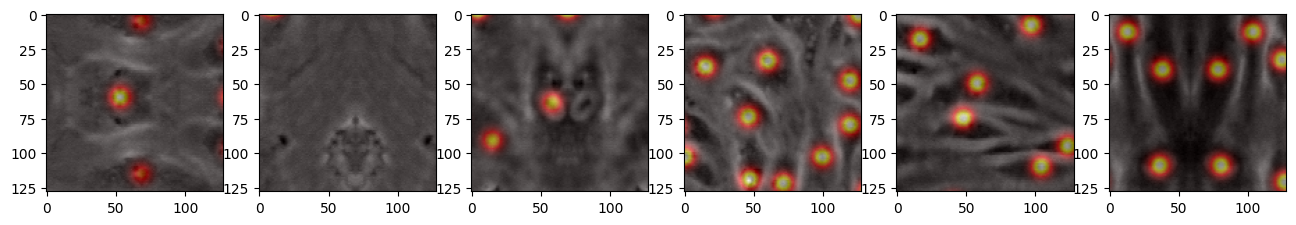

In [4]:
data,target = training_generator.__getitem__(0)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 6))

for i in range(6):
    axes[i].imshow(data[i*batch_size//6], cmap=plt.cm.gray)
    axes[i].imshow(target[i*batch_size//6], alpha = 0.5, cmap=plt.cm.hot)

In [5]:
def splineWindow(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = window_size // 4
    
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    
    wind = wind.reshape(window_size, 1, 1)
    wind = wind * wind.transpose(1, 0, 2)
    
    return wind

def predict(image, model, subDivisions = 2):
    windowSize = model.layers[0].input_shape[0][1]
    
    subWindowSize = windowSize // subDivisions

    nx = (image.shape[0] + 2*subWindowSize) // subWindowSize
    ny = (image.shape[1] + 2*subWindowSize) // subWindowSize
    n = nx * ny

    bx1 = (nx * subWindowSize - image.shape[0]) // 2
    bx2 = nx * subWindowSize - image.shape[0] - bx1

    by1 = (ny * subWindowSize - image.shape[1]) // 2
    by2 = ny * subWindowSize - image.shape[1] - by1

    padded = np.pad(image, ((bx1,bx2), (by1,by2)), 'reflect')
    
    xrange = np.arange(0, padded.shape[0]-subWindowSize-1, subWindowSize)
    yrange = np.arange(0, padded.shape[1]-subWindowSize-1, subWindowSize)
    
    #assert(nx == xrange.shape[0] and ny == yrange.shape[1])
    
    data = np.zeros((n, windowSize, windowSize), dtype=np.float32)
    
    i = 0
    for y in yrange:
        for x in xrange:
            data[i] = padded[x:x+windowSize,y:y+windowSize].astype(float) / 255.0
            i += 1
    
    pred = model.predict(data.reshape(n, windowSize, windowSize, 1))
    
    wind = splineWindow(windowSize)
    pred *= wind
    
    output = np.zeros(padded.shape, dtype=np.float32)
    i = 0
    for y in yrange:
        for x in xrange:
            output[x:x+windowSize,y:y+windowSize] += pred[i].reshape(windowSize, windowSize)
            i += 1
     
    return output[bx1:image.shape[0], by1:image.shape[1]]

class CallbackImage(keras.callbacks.Callback):
    def __init__(self, model, freq, idenitfier, fileName):
        super().__init__() 
        self.model = model
        self.freq = freq
        self.file_name = fileName
        self.date = date.today().strftime("%Y%m%d")
        self.id = idenitfier
        out_dir = f'{self.date}_Progress/'
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)
            
        self.image = imread(fileName)[:,:,0]

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.freq != 0:
            return
        pred = predict(self.image, self.model)
        pred /= pred.max()
        imsave(f'{self.date}_Progress/p{self.id}-epoch{epoch+1}.png', (pred*255).astype(np.uint8))

In [6]:
model = res_unet(16, 5, 1, (128,128,1), 'relu', True, True, 'sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Model: "Res-UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv0_1 (Conv2D)               (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 BN0_1 (BatchNormalization)     (None, 128, 128, 16  64          ['Conv0_1[0][0]']                
                                )                                                        

In [7]:
callbacks = [
    CallbackImage(model, 1, 'ResModel', '20211013_Batch36MF_43h_004.png'),
    tf.keras.callbacks.ModelCheckpoint('CellCounterModelBest.h5', monitor='val_loss', verbose=2, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir="./logs"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)
]
results = model.fit(training_generator,validation_data=validation_generator,epochs=epochs, verbose=1, callbacks=callbacks,initial_epoch=start_epochs)

Epoch 1/25
12/12 [==============================] - 1s 41ms/steploss: 0.0751 - accura

Epoch 1: val_loss improved from inf to 0.22304, saving model to CellCounterModelBest.h5
354/354 [==============================] - 127s 338ms/step - loss: 0.0751 - accuracy: 0.7779 - val_loss: 0.2230 - val_accuracy: 0.7574 - lr: 0.0010
Epoch 2/25
12/12 [==============================] - 0s 26ms/steploss: 0.0486 - accura

Epoch 2: val_loss improved from 0.22304 to 0.08516, saving model to CellCounterModelBest.h5
354/354 [==============================] - 118s 332ms/step - loss: 0.0486 - accuracy: 0.7810 - val_loss: 0.0852 - val_accuracy: 0.7562 - lr: 0.0010
Epoch 3/25
12/12 [==============================] - 0s 25ms/steploss: 0.0468 - accura

Epoch 3: val_loss improved from 0.08516 to 0.05486, saving model to CellCounterModelBest.h5
354/354 [==============================] - 118s 332ms/step - loss: 0.0468 - accuracy: 0.7810 - val_loss: 0.0549 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 4/25
12/12 [=====

In [8]:
model.save('CellCounterModelLast.h5')

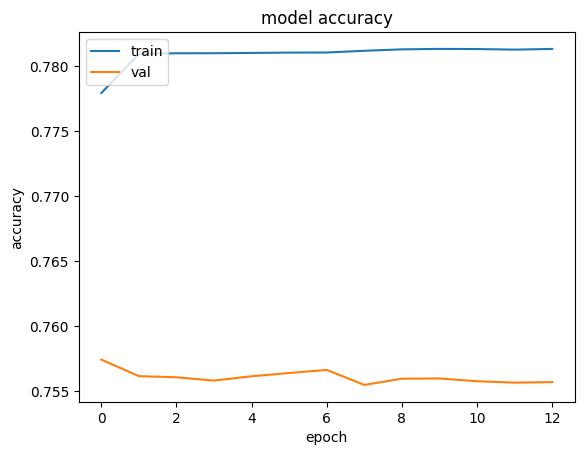

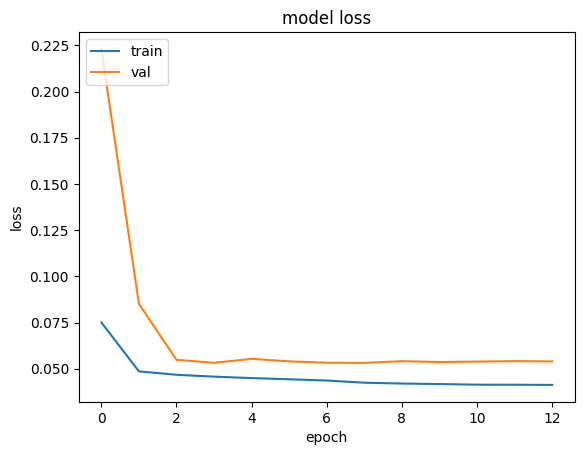

In [9]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
model_path = 'models'

os.makedirs(model_path, exist_ok=True)

onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, model_path + '/CellCounter.onnx')

## test read network in opencv
tensorflowNet = cv2.dnn.readNet(model_path + '/CellCounter.onnx')